In [62]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights
from umap.umap_ import UMAP
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.transforms import v2

In [63]:
class QuiltedDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        for img in os.listdir(folder_path):
            full_path = os.path.join(folder_path, img)
            #img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            #full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.append(full_path)

        for img in self.image_files:
            file_name = img.split("/")[-1]
            if "positive" in file_name:
                self.labels.append(1)
            else:
                self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [64]:
# Define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/positive_train/'
quilted_train_dataset = QuiltedDataset(folder_path, transform=transform)
quilted_train_dataloader = DataLoader(quilted_train_dataset, batch_size=32, shuffle=True)


# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/positive_test/'
quilted_val_dataset = QuiltedDataset(folder_path, transform=transform)
quilted_val_dataloader = DataLoader(quilted_val_dataset, batch_size=32, shuffle=True)

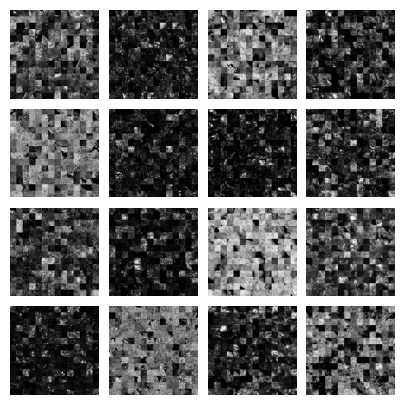

In [65]:
# Get a batch of 25 images for visualization
dataiter = iter(quilted_val_dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [66]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [67]:
# Define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_3snr_greyscale/'
test_dataset = SingleChannelDataset(folder_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [98]:
# Dataset implementation for your specific case
class MultiChannelQuiltedDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, num_objects=15, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.labels = [1] * num_objects
        self.samples = [[] for _ in range(num_objects*2)]


        
        img_names = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        img_names.sort()
        self.labels.extend([0] * num_objects)
        for img in img_names:
            tissue_num = int(img.split("/")[-1].split("_")[2])
            true_label = img.split("/")[-1].split("_")[1]
            img_tensor = self._load_image_as_tensor(os.path.join(folder_path, img))
            if true_label == "positive":
                self.samples[tissue_num].extend(img_tensor)
            else:
                self.samples[tissue_num+num_objects].extend(img_tensor)
            
    def _load_image_as_tensor(self, path):
        """
        Load an image as a NumPy array.
        
        Args:
            path (str): Path to image file
            
        Returns:
            np.ndarray: Image as NumPy array with shape [H, W]
        """
        # Open image using PIL
        with Image.open(path) as img:
            # Convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # Convert to NumPy array
            img_np = np.array(img, dtype=np.float32)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            #transform the tensor if needed
            if self.transform:
                img_tensor = self.transform(img_tensor)
        return img_tensor
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        
        
        # Stack list of images for each tissue to form a 50-channel tensor
        sample_tensor = torch.stack(sample, dim=0)  # Shape: [50, H, W]
        sample_tensor = sample_tensor.squeeze(1) # remove the color channel for each individual image, so the multidimensional
            
        return sample_tensor, label

In [99]:
# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/positive_train/'
mc_quilted_train_dataset = MultiChannelQuiltedDataset(folder_path, num_objects=15, transform=None)
mc_quilted_train_dataloader = DataLoader(mc_quilted_train_dataset, batch_size=4, shuffle=True)


# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/positive_test/'
mc_quilted_val_dataset = MultiChannelQuiltedDataset(folder_path, num_objects=6, transform=None)
mc_quilted_val_dataloader = DataLoader(mc_quilted_val_dataset, batch_size=4, shuffle=True)

In [97]:
class MultiChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Initialize the dataset by grouping images from the folder based on the random channel identifier
        and assigning labels based on positive/negative in filename.
        
        Args:
            folder_path (str): Path to the folder containing images
            transform (callable, optional): Optional transform to be applied on images
        """
        self.folder_path = folder_path
        self.transform = transform or transforms.ToTensor()
        
        # Get all image files in the folder
        self.image_files = [f for f in os.listdir(folder_path) 
                           if f.endswith('.png') and ('positive' in f or 'negative' in f)]
        
        # Group images by channel identifier
        self.grouped_data = self._group_images()
        
        # Create sample indices for accessing grouped data
        self.sample_indices = list(self.grouped_data.keys())
    
    def _group_images(self):
        """
        Group images by their unique channel identifier and assign labels.
        Returns a dictionary with channel identifiers as keys and (images_paths, label) as values.
        """
        grouped_data = {}
        
        # Regular expression to extract label and channel identifier
        # This assumes format: "Train_[positive|negative]_[randomstring]_channel.png"
        pattern = r'Train_(positive|negative)_(.+)_channel\.png'
        
        for img_file in self.image_files:
            match = re.match(pattern, img_file)
            if match:
                label_text, channel_id = match.groups()
                
                # Assign label: 1 for positive, 0 for negative
                label = 1 if label_text == 'positive' else 0
                
                # Get full path to the image
                img_path = os.path.join(self.folder_path, img_file)
                
                # Initialize the group if it doesn't exist
                if channel_id not in grouped_data:
                    grouped_data[channel_id] = {'paths': [], 'label': label}
                
                # Add image path to the group
                grouped_data[channel_id]['paths'].append(img_path)
                
                # Verify label consistency (all images in a group should have the same label)
                if grouped_data[channel_id]['label'] != label:
                    print(f"Warning: Inconsistent labels for channel {channel_id}")
        
        return grouped_data
    
    def __len__(self):
        """Return the number of samples (groups) in the dataset."""
        return len(self.grouped_data)
    
    def __getitem__(self, idx):
        """
        Return a sample from the dataset.
        
        Args:
            idx (int): Index of the sample
        
        Returns:
            tuple: (stacked_tensor, label) where stacked_tensor is a tensor
                  with all images from the group stacked together
        """
        # Get the channel identifier for this index
        channel_id = self.sample_indices[idx]
        
        # Get image paths and label for this group
        image_paths = self.grouped_data[channel_id]['paths']
        label = self.grouped_data[channel_id]['label']
        
        # Load all images in this group
        images = []
        for img_path in image_paths:
            img = Image.open(img_path).convert('RGB')
            
            # Apply transform if provided
            if self.transform:
                img = self.transform(img)
            
            images.append(img)
        
        # Stack all images into a single tensor
        # If images are already tensors (from transform), stack them directly
        if isinstance(images[0], torch.Tensor):
            stacked_tensor = torch.stack(images, dim=0)
        else:
            # Convert to numpy arrays and then to tensor
            images_np = [np.array(img) for img in images]
            stacked_tensor = torch.tensor(np.stack(images_np, axis=0))
        
        return stacked_tensor, label
    
    def get_channel_id(self, idx):
        """Return the channel identifier for a given index."""
        return self.sample_indices[idx]
    
    def get_all_channel_ids(self):
        """Return all channel identifiers in the dataset."""
        return self.sample_indices

In [72]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2):
        """
        Modified ResNet model to handle multi-channel inputs beyond RGB.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
        """
        super(MultiChannelResnet, self).__init__()
        
        # Load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # Initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # Scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # Only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # Initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # Replace the layer
        self.model.conv1 = new_layer
        
        # Modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        return self.model(x)

In [96]:
def train_model_with_visualization(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    device = "cuda"
    # Lists to store metrics for visualization
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    

    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        # Store training metrics
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        # Testing phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        # Calculate testing metrics
        val_accuracy = correct / total
        
        # Store validation metrics
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
                # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_restnet_classifier.pt')
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
    print(train_accs)
    print(val_accs)
    
    return train_losses,val_losses, train_accs, val_accs

def plot_metrics(train_losses,val_losses, train_accs, val_accs, epochs=10):
    """
    Plot training and validation metrics.
    
    Args:
        train_losses: List of training losses per epoch
       val_losses: List of validation losses per epoch
        train_accs: List of training accuracies per epoch
        val_accs: List of validation accuracies per epoch
        epochs: Number of training epochs
    """
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range,val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()


In [73]:

# Create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-3)

# Train with visualization
train_losses, val_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, quilted_train_dataloader, quilted_val_dataloader, epochs=10)

Epoch 1/10, Train Loss: 81.5830, Train Acc: 0.8407, Val Loss: 79.9689, Val Acc: 0.6827
Saved new best model with validation loss: 79.9689
Epoch 2/10, Train Loss: 27.0780, Train Acc: 0.9529, Val Loss: 82.0625, Val Acc: 0.7667
Epoch 3/10, Train Loss: 18.4079, Train Acc: 0.9682, Val Loss: 28.4557, Val Acc: 0.8897
Saved new best model with validation loss: 28.4557
Epoch 4/10, Train Loss: 13.7771, Train Acc: 0.9787, Val Loss: 35.0515, Val Acc: 0.9016
Epoch 5/10, Train Loss: 9.6927, Train Acc: 0.9863, Val Loss: 28.4173, Val Acc: 0.8934
Saved new best model with validation loss: 28.4173
Epoch 6/10, Train Loss: 7.0246, Train Acc: 0.9877, Val Loss: 26.7930, Val Acc: 0.9290
Saved new best model with validation loss: 26.7930
Epoch 7/10, Train Loss: 10.1502, Train Acc: 0.9840, Val Loss: 67.6689, Val Acc: 0.8497
Epoch 8/10, Train Loss: 10.0059, Train Acc: 0.9861, Val Loss: 8.5237, Val Acc: 0.9658
Saved new best model with validation loss: 8.5237
Epoch 9/10, Train Loss: 6.6352, Train Acc: 0.9904, Va

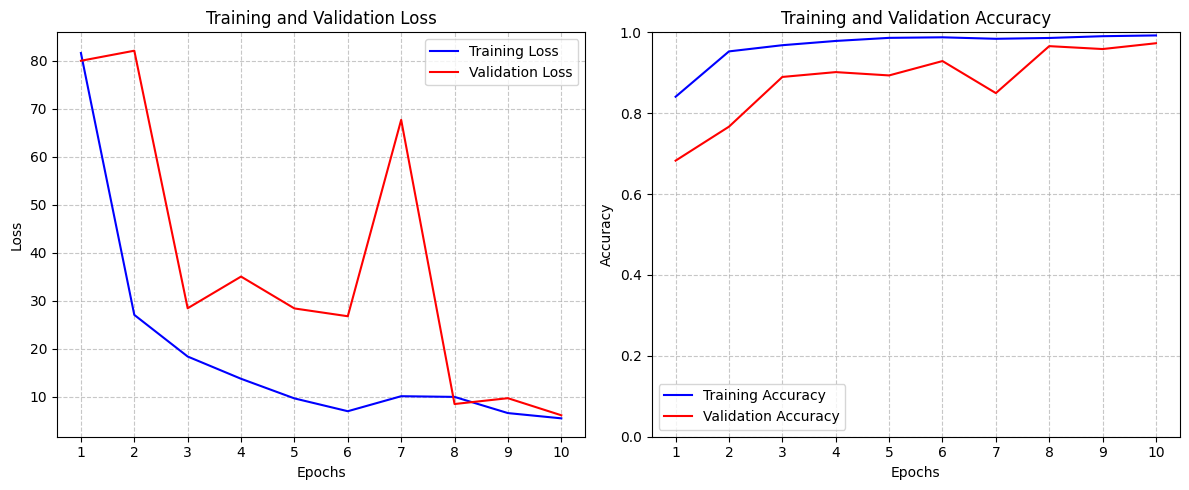

In [74]:

plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load the saved model
model = MultiChannelResnet(num_channels=1, num_classes=2).to('cpu')
model.load_state_dict(torch.load('best_restnet_classifier.pt', map_location=torch.device('cpu')))
model.eval()  # Set to evaluation mode



# 3. Make predictions
predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        all_labels.extend(labels.cpu().numpy())
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

y_pred = np.array(predictions)
y_true = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.6436

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.37      0.51      2440
           1       0.59      0.92      0.72      2440

    accuracy                           0.64      4880
   macro avg       0.70      0.64      0.62      4880
weighted avg       0.70      0.64      0.62      4880


Confusion Matrix:
[[ 905 1535]
 [ 204 2236]]


In [100]:
# Create model
model = MultiChannelResnet(num_channels=244, num_classes=2).to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-3)

# Train with visualization
train_losses, val_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, mc_quilted_train_dataloader, mc_quilted_val_dataloader, epochs=10)

Epoch 1/10, Train Loss: 6.9788, Train Acc: 0.5333, Val Loss: 1.8014, Val Acc: 0.5833
Saved new best model with validation loss: 1.8014
Epoch 2/10, Train Loss: 1.7368, Train Acc: 0.9333, Val Loss: 7.7054, Val Acc: 0.5000
Epoch 3/10, Train Loss: 1.5324, Train Acc: 0.9333, Val Loss: 24.0447, Val Acc: 0.5000
Epoch 4/10, Train Loss: 1.5359, Train Acc: 0.9667, Val Loss: 32.3128, Val Acc: 0.5000
Epoch 5/10, Train Loss: 6.3783, Train Acc: 0.8667, Val Loss: 7.1308, Val Acc: 0.5000
Epoch 6/10, Train Loss: 5.3019, Train Acc: 0.8000, Val Loss: 0.3232, Val Acc: 1.0000
Saved new best model with validation loss: 0.3232
Epoch 7/10, Train Loss: 1.6817, Train Acc: 0.9667, Val Loss: 0.1049, Val Acc: 1.0000
Saved new best model with validation loss: 0.1049
Epoch 8/10, Train Loss: 0.2832, Train Acc: 1.0000, Val Loss: 0.0708, Val Acc: 1.0000
Saved new best model with validation loss: 0.0708
Epoch 9/10, Train Loss: 0.0769, Train Acc: 1.0000, Val Loss: 0.0135, Val Acc: 1.0000
Saved new best model with validat

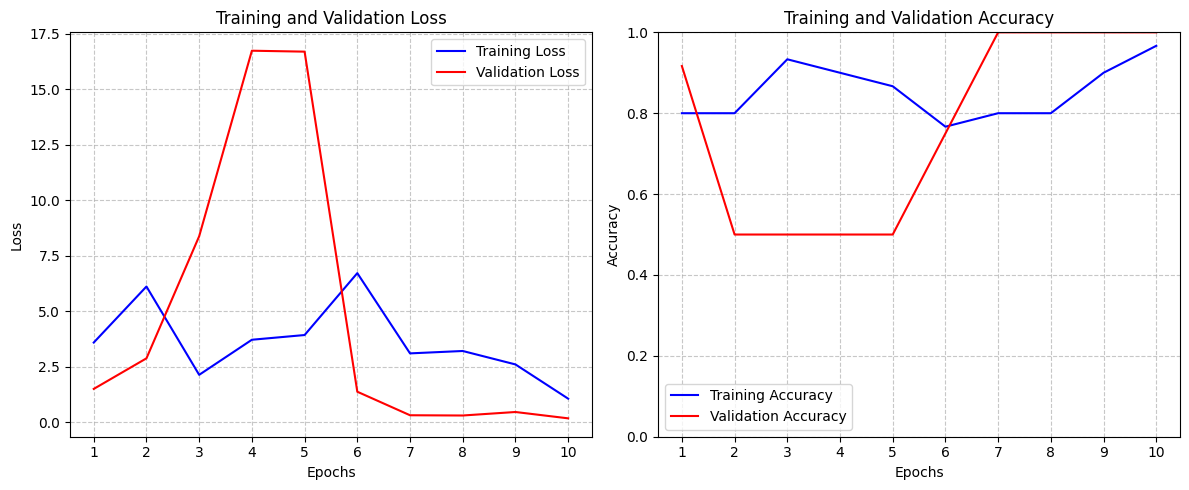

In [95]:

plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [60]:
# U-Net model for classification
class UNetForClassification(nn.Module):
    def __init__(self, n_channels=1, n_classes=2):
        super(UNetForClassification, self).__init__()
        
        # Encoder (downsampling)
        self.inc = self.double_conv(n_channels, 64)
        self.down1 = self.down(64, 128)
        self.down2 = self.down(128, 256)
        self.down3 = self.down(256, 512)
        
        # Bridge
        self.down4 = self.down(512, 1024)
        
        # Decoder (upsampling) - simplified for classification
        self.up1 = self.up(1024, 512)
        self.up2 = self.up(512, 256)
        
        # Classification head
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self.double_conv(in_channels, out_channels)
        )
    
    def up(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)          # Input: [batch, 1, H, W], Output: [batch, 64, H, W]
        x2 = self.down1(x1)       # Output: [batch, 128, H/2, W/2]
        x3 = self.down2(x2)       # Output: [batch, 256, H/4, W/4]
        x4 = self.down3(x3)       # Output: [batch, 512, H/8, W/8]
        x5 = self.down4(x4)       # Output: [batch, 1024, H/16, W/16]
        
        # Decoder (simplified for classification)
        x = self.up1(x5)          # Output: [batch, 512, H/8, W/8]
        x = self.up2(x)           # Output: [batch, 256, H/4, W/4]
        
        # Classification head
        x = self.avg_pool(x)      # Output: [batch, 256, 1, 1]
        x = x.view(x.size(0), -1) # Output: [batch, 256]
        x = self.classifier(x)    # Output: [batch, n_classes]
        
        return x

In [62]:
# Define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/'
quilted_dataset = QuiltedDataset(folder_path, transform=transform)
quilted_dataloader = DataLoader(quilted_dataset, batch_size=32, shuffle=True)

In [66]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np


class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # Store tumor type in self.labels (0 = fused glands, 1 = 141541)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        
        if self.transform:
            image = self.transform(image)
            
        return image, label  # Return both image and label

class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, num_classes, cutmix_prob=0.5, alpha=1.0):
        self.dataset = original_dataset
        self.cutmix = v2.CutMix(num_classes=num_classes, alpha=alpha)
        self.cutmix_prob = cutmix_prob
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        self.num_classes = num_classes
   
    def __len__(self):
        return len(self.dataset)
   
    def __getitem__(self, index):
        # Get the original image and label
        img, label = self.dataset[index]
        img = self.transform(img)
        
        # Decide whether to use CutMix based on probability
        use_cutmix = torch.rand(1).item() < self.cutmix_prob
        
        if not use_cutmix:
            # Return original image with its class index
            return img, label
        
        # If using CutMix, get a second random image
        idx2 = torch.randint(len(self.dataset), (1,)).item()
        img2, label2 = self.dataset[idx2]
        img2 = self.transform(img2)
        
        # Create batch of two images and their labels
        batch = torch.stack([img, img2])
        labels = torch.tensor([label, label2], dtype=torch.long)
        
        # Apply CutMix
        mixed_batch, mixed_labels = self.cutmix(batch, labels)
        
        # Convert probability distribution back to class index
        pred_label = mixed_labels[0].argmax().item()
        
        return mixed_batch[0], pred_label

# 3. Your UNetForClassification class (fixed formatting)
class UNetForClassification(nn.Module):
    def __init__(self, n_channels=1, n_classes=2):
        super(UNetForClassification, self).__init__()
        
        # Encoder (downsampling)
        self.inc = self.double_conv(n_channels, 64)
        self.down1 = self.down(64, 128)
        self.down2 = self.down(128, 256)
        self.down3 = self.down(256, 512)
        
        # Bridge
        self.down4 = self.down(512, 1024)
        
        # Decoder (upsampling) - simplified for classification
        self.up1 = self.up(1024, 512)
        self.up2 = self.up(512, 256)
        
        # Classification head
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder path (simplified for classification)
        x = self.up1(x5)
        x = self.up2(x)
        
        # Classification head
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self.double_conv(in_channels, out_channels)
        )
    
    def up(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

# 4. Training and visualization functions
def train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    # Initialize lists to keep track of metrics
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    device = next(model.parameters()).device
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Testing phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        test_loss = running_loss / total
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    return train_losses, test_losses, train_accs, test_accs

def plot_metrics(train_losses, test_losses, train_accs, test_accs, epochs):
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Training Accuracy')
    plt.plot(epochs_range, test_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 5. Main execution block for UNet
def main_unet():
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # UNet typically works well with powers of 2
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # For single channel
    ])
    
    quilted_dataset = QuiltedDataset(folder_path, transform=transform)
    quilted_dataloader = DataLoader(quilted_dataset, batch_size=32, shuffle=True)
    
    train_size = int(0.6 * len(quilted_dataset))  # 60% for training
    val_size = len(quilted_dataset) - train_size  # Remaining 40% for testing
    train_quilted_dataset, val_quilted_dataset = random_split(quilted_dataset, [train_size, val_size], generator = torch.Generator().manual_seed(42))

    # Define DataLoaders
    train_quilted_loader = DataLoader(train_quilted_dataset, batch_size=32, shuffle=True)
    val_quilted_loader = DataLoader(val_quilted_dataset, batch_size=32, shuffle=False)
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create UNet model
    model = UNetForClassification(n_channels=1, n_classes=2).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train with visualization
    train_losses, test_losses, train_accs, test_accs = train_model_with_visualization(
        model, criterion, optimizer, train_quilted_loader, val_quilted_loader, epochs=20
    )
    
    # Plot metrics
    plot_metrics(train_losses, test_losses, train_accs, test_accs, epochs=20)
    
    # Save the model
    torch.save(model.state_dict(), "tumor_classifier_unet.pth")
    print("Model saved to tumor_classifier_unet.pth")

# Run the UNet training
if __name__ == "__main__":
    main_unet()

Using device: cuda
Epoch 1/20:
Train Loss: 0.2813, Train Acc: 0.8800
Test Loss: 27.6889, Test Acc: 0.5138
Epoch 2/20:
Train Loss: 0.1218, Train Acc: 0.9550
Test Loss: 0.7071, Test Acc: 0.7675
Epoch 3/20:
Train Loss: 0.0654, Train Acc: 0.9758
Test Loss: 0.1060, Test Acc: 0.9663
Epoch 4/20:
Train Loss: 0.0367, Train Acc: 0.9867
Test Loss: 27.9351, Test Acc: 0.5138
Epoch 5/20:
Train Loss: 0.0437, Train Acc: 0.9808
Test Loss: 1.1577, Test Acc: 0.7150
Epoch 6/20:
Train Loss: 0.0209, Train Acc: 0.9908
Test Loss: 3.4237, Test Acc: 0.5425
Epoch 7/20:
Train Loss: 0.0860, Train Acc: 0.9700
Test Loss: 1.8562, Test Acc: 0.5050
Epoch 8/20:
Train Loss: 0.0365, Train Acc: 0.9875
Test Loss: 0.0452, Test Acc: 0.9800
Epoch 9/20:
Train Loss: 0.0434, Train Acc: 0.9867
Test Loss: 5.7657, Test Acc: 0.4863
Epoch 10/20:
Train Loss: 0.0137, Train Acc: 0.9975
Test Loss: 0.6973, Test Acc: 0.7700
Epoch 11/20:
Train Loss: 0.0110, Train Acc: 0.9967
Test Loss: 0.0573, Test Acc: 0.9838
Epoch 12/20:
Train Loss: 0.0716

KeyboardInterrupt: 